# 🧪 Experiment 3: Flan-T5-Small

## 🎯 Hypothesis
Flan-T5-Base (250M) was too large and harder to fine-tune. Flan-T5-Small (80M - similar to T5-Small) might provide better instruction-following with similar trainability.

## 🔬 Changes:
- ✅ Model: **google/flan-t5-small** (80M params - instruction-tuned)
- ✅ Lower learning rate: 3e-5 (Flan models need gentler fine-tuning)
- ✅ Sequence lengths: 256/512 (restored)
- ✅ Same training setup as Experiment 1
- ✅ Simpler prompt (Flan already understands instructions)

**Key Advantage:** Flan-T5 is instruction-tuned, so it should understand medical QA better

**Baseline to Beat:**
- BLEU: 0.0283
- ROUGE-L: 0.2102


In [4]:
%pip install -q tf-keras transformers tensorflow pandas numpy scikit-learn datasets evaluate rouge-score sacrebleu matplotlib seaborn
print("✓ Installed!")


✓ Installed!


In [5]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, json
from pathlib import Path
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from datasets import Dataset
import evaluate, tensorflow as tf, tf_keras
from datetime import datetime

SEED = 42; np.random.seed(SEED); tf.random.set_seed(SEED)
print(f"TF: {tf.__version__}")


TF: 2.19.0


In [6]:
train_df = pd.read_csv('/content/train_improved.csv')
val_df = pd.read_csv('/content/val_improved.csv')
test_df = pd.read_csv('/content/test_improved.csv')
print(f"Data: {len(train_df):,} train | {len(val_df):,} val | {len(test_df):,} test")


Data: 13,187 train | 1,648 val | 1,649 test


In [7]:
MODEL_NAME = "google/flan-t5-small"  # Instruction-tuned!
MAX_INPUT_LENGTH = 256
MAX_TARGET_LENGTH = 512

print(f"🚀 Loading {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Vocab: {len(tokenizer):,}")


🚀 Loading google/flan-t5-small


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

✓ Vocab: 32,100


In [8]:
def preprocess_function(examples):
    # Simpler prompt - Flan-T5 understands instructions already
    prefix = "Answer this medical question: "
    inputs = [prefix + q for q in examples['question']]
    targets = examples['answer']

    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=MAX_TARGET_LENGTH, truncation=True, padding='max_length')
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

tok_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tok_val = val_ds.map(preprocess_function, batched=True, remove_columns=val_ds.column_names)
tok_test = test_ds.map(preprocess_function, batched=True, remove_columns=test_ds.column_names)

print("✓ Tokenized")


Map:   0%|          | 0/13187 [00:00<?, ? examples/s]

Map:   0%|          | 0/1648 [00:00<?, ? examples/s]

Map:   0%|          | 0/1649 [00:00<?, ? examples/s]

✓ Tokenized


In [10]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, from_pt=True, use_safetensors=False)
print(f"✓ Model: {model.num_parameters():,} params")


pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


✓ Model: 76,961,152 params


In [11]:
# LOWER LR FOR FLAN MODELS
BATCH_SIZE = 8
LEARNING_RATE = 3e-5  # Lower than regular T5!
EPOCHS = 8
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

print(f"Hyperparams: LR={LEARNING_RATE} (gentler for Flan), Epochs={EPOCHS}")

tf_train = model.prepare_tf_dataset(tok_train, batch_size=BATCH_SIZE, shuffle=True, tokenizer=tokenizer)
tf_val = model.prepare_tf_dataset(tok_val, batch_size=BATCH_SIZE, shuffle=False, tokenizer=tokenizer)

# Optimizer setup
num_steps = len(tf_train) * EPOCHS
num_warmup = int(WARMUP_RATIO * num_steps)

lr_schedule = tf_keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=LEARNING_RATE, decay_steps=num_steps - num_warmup, end_learning_rate=1e-7
)

class WarmupSchedule(tf_keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, post_warmup_schedule):
        super().__init__()
        self.warmup_steps = warmup_steps
        self.post_warmup_schedule = post_warmup_schedule
        self.learning_rate = LEARNING_RATE

    def __call__(self, step):
        step = tf.cast(step, tf.float32); warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_lr = self.learning_rate * (step / warmup_steps)
        decay_lr = self.post_warmup_schedule(step - warmup_steps)
        return tf.cond(step < warmup_steps, lambda: warmup_lr, lambda: decay_lr)

optimizer = tf_keras.optimizers.AdamW(learning_rate=WarmupSchedule(num_warmup, lr_schedule), weight_decay=WEIGHT_DECAY)
model.compile(optimizer=optimizer)
print("✓ Optimizer ready")


Hyperparams: LR=3e-05 (gentler for Flan), Epochs=8
✓ Optimizer ready


In [12]:
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint

Path('models/experiment_3').mkdir(parents=True, exist_ok=True)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint('models/experiment_3/best.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
]

print("="*80)
print("🚀 EXPERIMENT 3: FLAN-T5-SMALL (Instruction-Tuned)")
print("="*80)

start_time = datetime.now()
history = model.fit(tf_train, validation_data=tf_val, epochs=EPOCHS, callbacks=callbacks, verbose=1)
training_time = (datetime.now() - start_time).total_seconds()

print(f"\\n✓ Complete in {training_time/60:.1f} min")


🚀 EXPERIMENT 3: FLAN-T5-SMALL (Instruction-Tuned)
Epoch 1/8
1648/1648 [==============================] - ETA: 0s - loss: 6.4159
Epoch 1: val_loss improved from inf to 1.22969, saving model to models/experiment_3/best.h5
1648/1648 [==============================] - 1189s 681ms/step - loss: 6.4159 - val_loss: 1.2297
Epoch 2/8
1648/1648 [==============================] - ETA: 0s - loss: 1.2952
Epoch 2: val_loss improved from 1.22969 to 1.04432, saving model to models/experiment_3/best.h5
1648/1648 [==============================] - 1070s 649ms/step - loss: 1.2952 - val_loss: 1.0443
Epoch 3/8
1648/1648 [==============================] - ETA: 0s - loss: 1.1384
Epoch 3: val_loss improved from 1.04432 to 0.97107, saving model to models/experiment_3/best.h5
1648/1648 [==============================] - 1066s 647ms/step - loss: 1.1384 - val_loss: 0.9711
Epoch 4/8
1648/1648 [==============================] - ETA: 0s - loss: 1.0688
Epoch 4: val_loss improved from 0.97107 to 0.93768, saving model t

FileNotFoundError: [Errno 2] No such file or directory: 'data/improved/experiment_3_training.png'

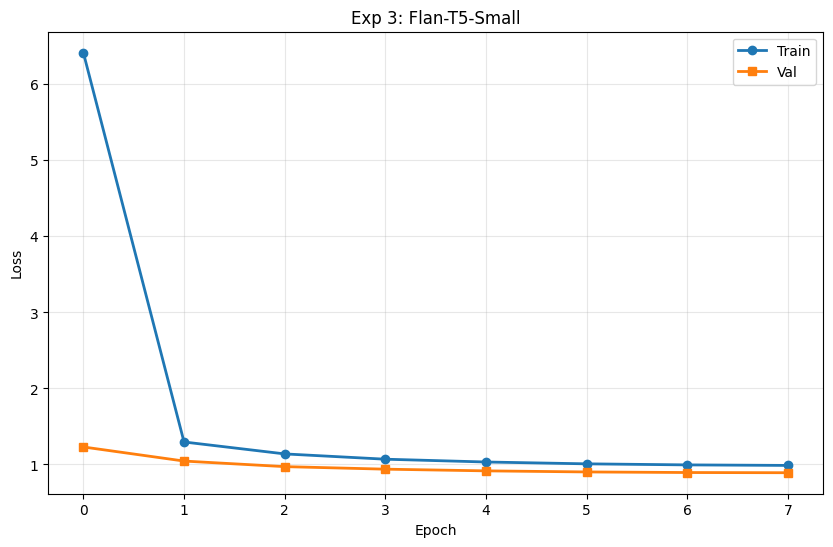

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], 'o-', label='Train', lw=2)
plt.plot(history.history['val_loss'], 's-', label='Val', lw=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Exp 3: Flan-T5-Small')
plt.legend(); plt.grid(True, alpha=0.3)
plt.savefig('data/improved/experiment_3_training.png', dpi=300)
plt.show()
print(f"Best Val: {min(history.history['val_loss']):.4f}")


In [20]:
# Evaluation
def generate_answer(question, model, tokenizer):
    prefix = "Answer this medical question: "
    inputs = tokenizer(prefix + question, return_tensors='tf', max_length=MAX_INPUT_LENGTH, truncation=True)
    outputs = model.generate(**inputs, max_length=512, min_length=10, num_beams=4, early_stopping=True,
                            no_repeat_ngram_size=3, length_penalty=1.0, do_sample=False)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

print("Generating predictions...")
predictions, references = [], []
for i in range(min(20, len(test_df))):
    q = test_df.iloc[i]['question']
    predictions.append(generate_answer(q, model, tokenizer))
    references.append(test_df.iloc[i]['answer'])
    if (i+1) % 5 == 0: print(f"  {i+1}/200...")

bleu_result = bleu_metric.compute(predictions=predictions, references=[[r] for r in references])
rouge_result = rouge_metric.compute(predictions=predictions, references=references)
val_loss = min(history.history['val_loss'])

print("\\n" + "="*80)
print("📊 EXPERIMENT 3 RESULTS")
print("="*80)
print(f"BLEU:     {bleu_result['bleu']:.4f}")
print(f"ROUGE-L:  {rouge_result['rougeL']:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print("="*80)

# Save results
results = {
    'experiment_id': 'exp3_flan_t5_small',
    'experiment_name': 'Flan-T5-Small (Instruction-Tuned)',
    'model_name': MODEL_NAME,
    'model_params': int(model.num_parameters()),
    'hyperparameters': {'batch_size': BATCH_SIZE, 'learning_rate': LEARNING_RATE, 'epochs': EPOCHS,
                       'max_input_length': MAX_INPUT_LENGTH, 'max_target_length': MAX_TARGET_LENGTH},
    'metrics': {'bleu': float(bleu_result['bleu']), 'rougeL': float(rouge_result['rougeL']), 'val_loss': float(val_loss)},
    'training_time_seconds': training_time
}

Path('results').mkdir(exist_ok=True)
with open('results/experiment_3_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print("\\n✓ Saved to results/experiment_3_results.json")


Generating predictions...
  5/200...
  10/200...
  15/200...
  20/200...
\n================================================================================
📊 EXPERIMENT 3 RESULTS
BLEU:     0.0777
ROUGE-L:  0.2631
Val Loss: 0.8909
\n✓ Saved to results/experiment_3_results.json


In [ ]:
# Show sample predictions
print("\\n" + "="*80)
print("🔍 SAMPLE PREDICTIONS")
print("="*80)

for i in range(min(3, len(test_df))):
    q = test_df.iloc[i]['question']
    true_a = test_df.iloc[i]['answer']
    pred_a = predictions[i]

    print(f"\\nQ: {q}")
    print(f"True: {true_a[:150]}..." if len(true_a) > 150 else f"True: {true_a}")
    print(f"Pred: {pred_a[:150]}..." if len(pred_a) > 150 else f"Pred: {pred_a}")
    print("-" * 80)